In [1]:
import numpy as np

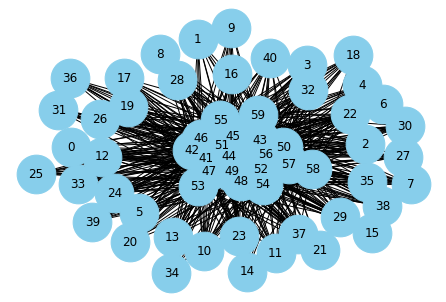

In [183]:

def pagerank(G, alpha=0.85, personalization=None, 
             max_iter=100, tol=1.0e-6, nstart=None, weight='weight', 
             dangling=None): b 
    """Return the PageRank of the nodes in the graph. 
  
    PageRank computes a ranking of the nodes in the graph G based on 
    the structure of the incoming links. It was originally designed as 
    an algorithm to rank web pages. 
  
    Parameters 
    ---------- 
    G : graph 
      A NetworkX graph.  Undirected graphs will be converted to a directed 
      graph with two directed edges for each undirected edge. 
  
    alpha : float, optional 
      Damping parameter for PageRank, default=0.85. 
  
    personalization: dict, optional 
      The "personalization vector" consisting of a dictionary with a 
      key for every graph node and nonzero personalization value for each node. 
      By default, a uniform distribution is used. 
  
    max_iter : integer, optional 
      Maximum number of iterations in power method eigenvalue solver. 
  
    tol : float, optional 
      Error tolerance used to check convergence in power method solver. 
  
    nstart : dictionary, optional 
      Starting value of PageRank iteration for each node. 
  
    weight : key, optional 
      Edge data key to use as weight.  If None weights are set to 1. 
  
    dangling: dict, optional 
      The outedges to be assigned to any "dangling" nodes, i.e., nodes without 
      any outedges. The dict key is the node the outedge points to and the dict 
      value is the weight of that outedge. By default, dangling nodes are given 
      outedges according to the personalization vector (uniform if not 
      specified). This must be selected to result in an irreducible transition 
      matrix (see notes under google_matrix). It may be common to have the 
      dangling dict to be the same as the personalization dict. 
  
    Returns 
    ------- 
    pagerank : dictionary 
       Dictionary of nodes with PageRank as value 
  
    Notes 
    ----- 
    The eigenvector calculation is done by the power iteration method 
    and has no guarantee of convergence.  The iteration will stop 
    after max_iter iterations or an error tolerance of 
    number_of_nodes(G)*tol has been reached. 
  
    The PageRank algorithm was designed for directed graphs but this 
    algorithm does not check if the input graph is directed and will 
    execute on undirected graphs by converting each edge in the 
    directed graph to two edges. 
  
      
    """
    if len(G) == 0: 
        return {} 
  
    if not G.is_directed(): 
        D = G.to_directed() 
    else: 
        D = G 
  
    # Create a copy in (right) stochastic form 
    W = nx.stochastic_graph(D, weight=weight) 
    N = W.number_of_nodes() 
  
    # Choose fixed starting vector if not given 
    if nstart is None: 
        x = dict.fromkeys(W, 1.0 / N) 
    else: 
        # Normalized nstart vector 
        s = float(sum(nstart.values())) 
        x = dict((k, v / s) for k, v in nstart.items()) 
  
    if personalization is None: 
  
        # Assign uniform personalization vector if not given 
        p = dict.fromkeys(W, 1.0 / N) 
    else: 
        missing = set(G) - set(personalization) 
        if missing: 
            raise NetworkXError('Personalization dictionary '
                                'must have a value for every node. '
                                'Missing nodes %s' % missing) 
        s = float(sum(personalization.values())) 
        p = dict((k, v / s) for k, v in personalization.items()) 
  
    if dangling is None: 
  
        # Use personalization vector if dangling vector not specified 
        dangling_weights = p 
    else: 
        missing = set(G) - set(dangling) 
        if missing: 
            raise NetworkXError('Dangling node dictionary '
                                'must have a value for every node. '
                                'Missing nodes %s' % missing) 
        s = float(sum(dangling.values())) 
        dangling_weights = dict((k, v/s) for k, v in dangling.items()) 
    dangling_nodes = [n for n in W if W.out_degree(n, weight=weight) == 0.0] 
  
    # power iteration: make up to max_iter iterations 
    for _ in range(max_iter): 
        xlast = x 
        x = dict.fromkeys(xlast.keys(), 0) 
        danglesum = alpha * sum(xlast[n] for n in dangling_nodes) 
        for n in x: 
  
            # this matrix multiply looks odd because it is 
            # doing a left multiply x^T=xlast^T*W 
            for nbr in W[n]: 
                x[nbr] += alpha * xlast[n] * W[n][nbr][weight] 
            x[n] += danglesum * dangling_weights[n] + (1.0 - alpha) * p[n] 
  
        # check convergence, l1 norm 
        err = sum([abs(x[n] - xlast[n]) for n in x]) 
        if err < N*tol: 
            return x 
    raise NetworkXError('pagerank: power iteration failed to converge '
                        'in %d iterations.' % max_iter) 



{'A': 0.20604385185185187,
 'B': 0.23351644444444447,
 'C': 0.23351644444444447,
 'D': 0.3269232592592593}

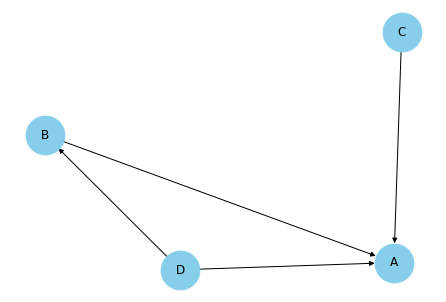

In [278]:
import networkx as nx 

data = np.array([[0, 1, 1, 3], 
                 [0, 0, 0, 1], 
                 [0, 0, 0, 0],
                 [0, 0, 0, 0]])

df = pd.DataFrame(data, index = ['A','B','C','D'], columns = ['A','B','C','D'])

G_pg = nx.from_pandas_adjacency(df, create_using=nx.DiGraph())
pr=nx.pagerank(G_pg,0.4, weight = 32) 
# input weights!


G_plot = nx.from_pandas_adjacency(df.T, create_using=nx.DiGraph())
nx.draw(G_plot, with_labels=True, node_color='skyblue', node_size=1500, width=1.0, edge_cmap=plt.cm.Blues)
pr

In [ ]:
pr=nx.pagerank(G,0.4) 
     

nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, width=1.0, edge_cmap=plt.cm.Blues)


In [236]:
nx.stochastic_graph(G, weight={}) 

networkx.classes.digraph.DiGraph

---

In [ ]:
import sqlite3

conn = sqlite3.connect('spider.sqlite')
cur = conn.cursor()

# Find the ids that send out page rank - we only are interested
# in pages in the SCC that have in and out links
cur.execute('''SELECT DISTINCT from_id FROM Links''')
from_ids = list()
for row in cur: 
    from_ids.append(row[0])

# Find the ids that receive page rank 
to_ids = list()
links = list()
cur.execute('''SELECT DISTINCT from_id, to_id FROM Links''')
for row in cur:
    from_id = row[0]
    to_id = row[1]
    if from_id == to_id : continue
    if from_id not in from_ids : continue
    if to_id not in from_ids : continue
    links.append(row)
    if to_id not in to_ids : to_ids.append(to_id)

# Get latest page ranks for strongly connected component
prev_ranks = dict()
for node in from_ids:
    cur.execute('''SELECT new_rank FROM Pages WHERE id = ?''', (node, ))
    row = cur.fetchone()
    prev_ranks[node] = row[0]

sval = raw_input('How many iterations:')
many = 1
if ( len(sval) > 0 ) : many = int(sval)

# Sanity check
if len(prev_ranks) < 1 : 
    print "Nothing to page rank.  Check data."
    quit()

# Lets do Page Rank in memory so it is really fast
for i in range(many):
    # print prev_ranks.items()[:5]
    next_ranks = dict();
    total = 0.0
    for (node, old_rank) in prev_ranks.items():
        total = total + old_rank
        next_ranks[node] = 0.0
    # print total

    # Find the number of outbound links and sent the page rank down each
    for (node, old_rank) in prev_ranks.items():
        # print node, old_rank
        give_ids = list()
        for (from_id, to_id) in links:
            if from_id != node : continue
           #  print '   ',from_id,to_id

            if to_id not in to_ids: continue
            give_ids.append(to_id)
        if ( len(give_ids) < 1 ) : continue
        amount = old_rank / len(give_ids)
        # print node, old_rank,amount, give_ids
    
        for id in give_ids:
            next_ranks[id] = next_ranks[id] + amount
    
    newtot = 0
    for (node, next_rank) in next_ranks.items():
        newtot = newtot + next_rank
    evap = (total - newtot) / len(next_ranks)

    # print newtot, evap
    for node in next_ranks:
        next_ranks[node] = next_ranks[node] + evap

    newtot = 0
    for (node, next_rank) in next_ranks.items():
        newtot = newtot + next_rank

    # Compute the per-page average change from old rank to new rank
    # As indication of convergence of the algorithm
    totdiff = 0
    for (node, old_rank) in prev_ranks.items():
        new_rank = next_ranks[node]
        diff = abs(old_rank-new_rank)
        totdiff = totdiff + diff

    avediff = totdiff / len(prev_ranks)
    print i+1, avediff

    # rotate
    prev_ranks = next_ranks

# Put the final ranks back into the database
print next_ranks.items()[:5]
cur.execute('''UPDATE Pages SET old_rank=new_rank''')
for (id, new_rank) in next_ranks.items() :
    cur.execute('''UPDATE Pages SET new_rank=? WHERE id=?''', (new_rank, id))
conn.commit()
cur.close()



In [293]:
def pagerank(M, eps=1.0e-8, d=0.85):
    N = M.shape[1]
    v = np.random.rand(N, 1)
    v = v / np.linalg.norm(v, 1)
    last_v = np.ones((N, 1), dtype=np.float32) * 100
    
    while np.linalg.norm(v - last_v, 2) > eps:
        last_v = v
        v = d * np.matmul(M, v) + (1 - d) / N
    return v

In [290]:
def my_pagerank(M):
    N = M.shape[1]
    pr = np.array([M[i][i] for i in range(N)]).T

    # new_pr = np.matmul(M, pr)
    for i in range(10):
        pr = np.matmul(M, pr)
        pr = pr / np.linalg.norm(pr, 1) #normalizing outside runs into overfloat
    return pr
    
#    new_pr = new_pr / np.linalg.norm(new_pr, 1)
 #   return new_pr

    '''
    
    pr = last_v = np.ones((N, 1), dtype=np.float32) * 100
    
    while np.linalg.norm(v - last_v, 2) > eps:
        last_v = v
        v = d * np.matmul(M, v) + (1 - d) / N
    
'''
    

[[0.87039375]
 [0.09646875]
 [0.069375  ]
 [0.0375    ]]


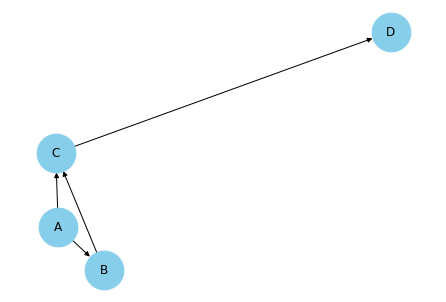

In [309]:
M = np.array([[0, 0, 3, 0],
              [0, 0, 1, 0],
              [0, 0, 0, 1],
              [0, 0, 0, 0]])

#[row] has impact on [col]
#M = M / np.linalg.norm(M, 1)
    
    
#N = sklearn.preprocessing.normalize(M, norm='l1', axis=1)

v = pagerank(M, 0.001)
#v = my_pagerank(N)
print(v)



df = pd.DataFrame(M, index = ['A','B','C','D'], columns = ['A','B','C','D'])
G_plot = nx.from_pandas_adjacency(df, create_using=nx.DiGraph())
nx.draw(G_plot, with_labels=True, node_color='skyblue', node_size=1500, width=1.0, edge_cmap=plt.cm.Blues)


In [287]:
import sklearn
from sklearn.preprocessing import Normalizer, normalize

N = sklearn.preprocessing.normalize(M, norm='l1', axis=1)
print(N)

[[0.33333333 0.33333333 0.33333333 0.        ]
 [0.         0.33333333 0.         0.66666667]
 [0.         0.         0.5        0.5       ]
 [0.         0.         0.         1.        ]]


## Heatmap

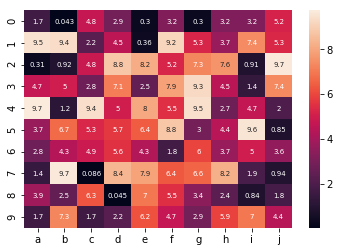

In [9]:
# library
import seaborn as sns
import pandas as pd
import numpy as np
 
# Create a dataset (fake)
df = pd.DataFrame(10*np.random.random((10,10)), columns=["a","b","c","d","e","f","g","h","i","j"])


sns.heatmap(df, annot=True, annot_kws={"size": 7})
#sns.plt.show()


## Bokeh

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
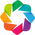

[{'source': 1, 'target': 0, 'value': 1}, {'source': 2, 'target': 0, 'value': 8}, {'source': 3, 'target': 0, 'value': 10}, {'source': 3, 'target': 2, 'value': 6}, {'source': 4, 'target': 0, 'value': 1}, {'source': 5, 'target': 0, 'value': 1}, {'source': 6, 'target': 0, 'value': 1}, {'source': 7, 'target': 0, 'value': 1}, {'source': 8, 'target': 0, 'value': 2}, {'source': 9, 'target': 0, 'value': 1}, {'source': 11, 'target': 10, 'value': 1}, {'source': 11, 'target': 3, 'value': 3}, {'source': 11, 'target': 2, 'value': 3}, {'source': 11, 'target': 0, 'value': 5}, {'source': 12, 'target': 11, 'value': 1}, {'source': 13, 'target': 11, 'value': 1}, {'source': 14, 'target': 11, 'value': 1}, {'source': 15, 'target': 11, 'value': 1}, {'source': 17, 'target': 16, 'value': 4}, {'source': 18, 'target': 16, 'value': 4}, {'source': 18, 'target': 17, 'value': 4}, {'source': 19, 'target': 16, 'value': 4}, {'source': 19, 'target': 17, 'value': 4}, {'source': 19, 'target': 18, 'value': 4}, {'source': 20

:Chord   [source,target]   (value)

In [45]:
import pandas as pd
import holoviews as hv
from holoviews import opts, dim

from bokeh.sampledata.les_mis import data
 
    
hv.extension('bokeh')
hv.output(size=200)

print(data['links'])


links = pd.DataFrame(data['links'])
print(links.head(3))

nodes = hv.Dataset(pd.DataFrame(data['nodes']), 'index')
print(nodes.data.head())


chord = hv.Chord((links, nodes)).select(value=(5, None))
chord.opts(
    opts.Chord(cmap='Category20', edge_cmap='Category20', edge_color=dim('source').str(), 
               labels='name', node_color=dim('index').str()))



In [44]:
thisdict =	{
  "brand": "Ford",
  "model": "Mustang",
  "year": 1964
}
print(thisdict.keys())

dict_keys(['brand', 'model', 'year'])


## networkx

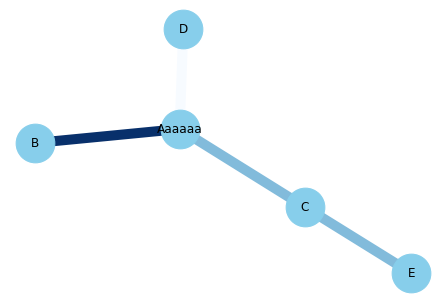

In [279]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
 
# Build a dataframe with your connections
df = pd.DataFrame({ 'from':['Aaaaaa', 'B', 'C','Aaaaaa'], 'to':['D', 'Aaaaaa', 'E','C'], 'value':[1, 10, 5, 5]})
df
 
# Build your graph
G=nx.from_pandas_edgelist(df, 'from', 'to', edge_attr=True) #.from_pandas_dataframe(df, 'from', 'to', create_using=nx.Graph() )
 
# Custom the nodes:
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_color=df['value'], width=10.0, edge_cmap=plt.cm.Blues)


In [280]:
df

,from,to,value
0,Aaaaaa,D,1
1,B,Aaaaaa,10
2,C,E,5
3,Aaaaaa,C,5
